# Metadata

```yaml
Course:    DS 5001
Module:    12 Lab
Topic:     Classification with Expected Mutual Information (EMI)
Author:    R.C. Alvarado
Date:      16 April 2023 (revised)
```

# Overview

Mutual information measures how much information is communicated, on average, in one random variable about another.

For example, if I know that a document contains a given word, how much information does that word commuicate about the class of the document?

The formula is the following:

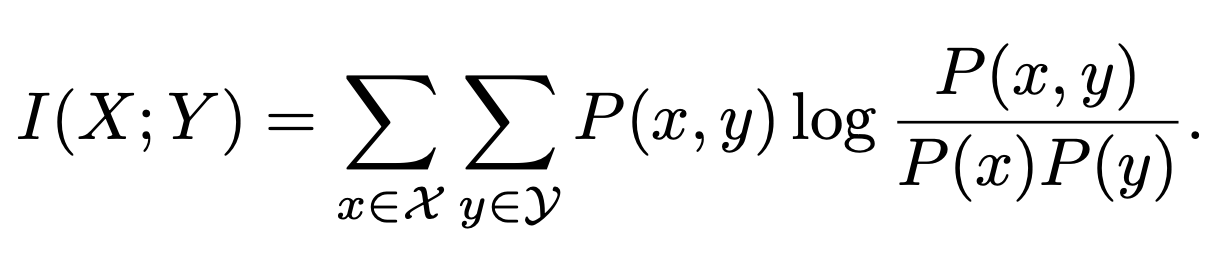

Note that this is an expectation of point-wise mutial information. 

Now, is we let $x$ stand for a word in a document, and $y$ for the label of a document, then we can estimate the values of each of the component probabilities and compute $I$.

To create a model, we can choose the value of $y$ with the maximum value for a given word $x$. Then we can apply this model to a test set.

# Set Up

## Configure

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
data_prefix = 'winereviews'
data_path = f"{data_home}/{data_prefix}/{data_prefix}"

In [3]:
class Params:
    smooth_alpha = .1

## Import

In [50]:
import pandas as pd
import numpy as np
import plotly_express as px

# Preparation

## Get Data

In [5]:
X_test = pd.read_pickle(f"{data_path}-X_test.csv.pickle").sort_index()
X_train = pd.read_pickle(f"{data_path}-X_train.csv.pickle").sort_index()
y_test = pd.read_pickle(f"{data_path}-y_test.csv.pickle").sort_index()
y_train = pd.read_pickle(f"{data_path}-y_train.csv.pickle").sort_index()

In [48]:
DOC = pd.read_csv(f"{data_path}-DOC_UNSPLIT.csv").set_index('doc_id')

# Training

## Label $P(y)$

In [6]:
TOKEN_CLASS = X_train.join(y_train.to_frame('doc_label'), how='inner').groupby('doc_label').sum().T

In [7]:
TOKEN_CLASS

doc_label,N,P
000,23,38
01,0,2
02,1,1
03,3,3
04,10,11
...,...,...
émilion,3,7
öküzgözü,1,2
über,1,4
überbest,0,1


In [8]:
CLASS = (TOKEN_CLASS.sum() / TOKEN_CLASS.sum().sum()).to_frame('p_y')

In [9]:
CLASS

,p_y
doc_label,
N,0.440325
P,0.559675


## Word $P(x)$

In [10]:
X_train_smooth = X_train + Params.smooth_alpha

In [11]:
VOCAB = (X_train_smooth.sum() / X_train_smooth.sum().sum()).to_frame('p_x')
VOCAB.index.name = 'term_str'

In [12]:
VOCAB

,p_x
term_str,
000,0.000049
01,0.000048
02,0.000048
03,0.000048
04,0.000048
...,...
émilion,0.000048
öküzgözü,0.000048
über,0.000048


## Word and Label $P(x,y)$

In [13]:
TOKEN_CLASS_SMOOTH = TOKEN_CLASS + Params.smooth_alpha

In [14]:
TOKEN_CLASS_NARROW = (TOKEN_CLASS_SMOOTH / TOKEN_CLASS_SMOOTH.sum().sum()).unstack().to_frame('p_xy')

In [15]:
TOKEN_CLASS_NARROW.index.names = ['doc_label', 'term_str']

In [16]:
TOKEN_CLASS_NARROW

p_xy
doc_label term_str              
N         000       2.963480e-05
          01        1.282892e-07
          02        1.411181e-06
          03        3.976964e-06
          04        1.295721e-05
...                          ...
P         émilion   9.108531e-06
          öküzgözü  2.694073e-06
          über      5.259856e-06
          überbest  1.411181e-06
          žilavka   1.282892e-07

[41280 rows x 1 columns]

## Point-wise mutual information

$pmi(x;y) = log_2(\large\frac{P(x,y)}{P(x)P(y)})$

In [17]:
TOKEN_CLASS_NARROW = TOKEN_CLASS_NARROW.join(VOCAB.p_x).join(CLASS.p_y)

In [18]:
TOKEN_CLASS_NARROW

p_xy       p_x       p_y
doc_label term_str                                  
N         000       2.963480e-05  0.000049  0.440325
          01        1.282892e-07  0.000048  0.440325
          02        1.411181e-06  0.000048  0.440325
          03        3.976964e-06  0.000048  0.440325
          04        1.295721e-05  0.000048  0.440325
...                          ...       ...       ...
P         émilion   9.108531e-06  0.000048  0.559675
          öküzgözü  2.694073e-06  0.000048  0.559675
          über      5.259856e-06  0.000048  0.559675
          überbest  1.411181e-06  0.000048  0.559675
          žilavka   1.282892e-07  0.000048  0.559675

[41280 rows x 3 columns]

In [19]:
TOKEN_CLASS_NARROW['pmi'] = np.log2(TOKEN_CLASS_NARROW.p_xy/(TOKEN_CLASS_NARROW.p_x * TOKEN_CLASS_NARROW.p_y))

In [20]:
TOKEN_CLASS_NARROW

p_xy       p_x       p_y       pmi
doc_label term_str                                            
N         000       2.963480e-05  0.000049  0.440325  0.463761
          01        1.282892e-07  0.000048  0.440325 -7.361647
          02        1.411181e-06  0.000048  0.440325 -3.902215
          03        3.976964e-06  0.000048  0.440325 -2.409252
          04        1.295721e-05  0.000048  0.440325 -0.711971
...                          ...       ...       ...       ...
P         émilion   9.108531e-06  0.000048  0.559675 -1.561519
          öküzgözü  2.694073e-06  0.000048  0.559675 -3.315799
          über      5.259856e-06  0.000048  0.559675 -2.351465
          überbest  1.411181e-06  0.000048  0.559675 -4.247784
          žilavka   1.282892e-07  0.000048  0.559675 -7.707216

[41280 rows x 4 columns]

In [21]:
PMI = TOKEN_CLASS_NARROW.pmi.unstack().T

In [22]:
PMI

doc_label,N,P
term_str,,
000,0.463761,0.839640
01,-7.361647,-3.315349
02,-3.902215,-4.248235
03,-2.409252,-2.755271
04,-0.711971,-0.921786
...,...,...
émilion,-2.411051,-1.561519
öküzgözü,-3.902666,-3.315799
über,-3.903566,-2.351465


## EMI

In [23]:
TOKEN_CLASS_NARROW['emi'] = TOKEN_CLASS_NARROW.p_xy * TOKEN_CLASS_NARROW.pmi

In [24]:
EMI = TOKEN_CLASS_NARROW.emi.unstack().T

In [25]:
EMI

doc_label,N,P
term_str,,
000,1.374346e-05,4.104006e-05
01,-9.444196e-07,-8.931791e-06
02,-5.506732e-06,-5.995028e-06
03,-9.581509e-06,-1.095761e-05
04,-9.225153e-06,-1.312632e-05
...,...,...
émilion,-9.588663e-06,-1.422315e-05
öküzgözü,-5.507368e-06,-8.933004e-06
über,-5.508638e-06,-1.236837e-05


# Testing

In [26]:
X_test.dot(EMI)

doc_label,N,P
doc_id,,
49,0.240874,0.274564
84,0.141473,0.169389
87,0.108076,0.140395
95,0.174012,0.258034
106,0.327286,0.343223
...,...,...
129936,0.201740,0.246359
129946,0.167545,0.190209
129948,0.204028,0.194124


In [27]:
y_hat = X_test.dot(EMI).idxmax(1)

# Evaluation

In [28]:
RESULT = pd.concat([y_test, y_hat], axis=1)
RESULT.columns = ['doc_label', 'prediction']

In [29]:
RESULT['result'] = RESULT.doc_label == RESULT.prediction

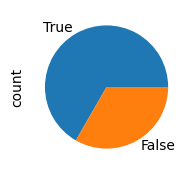

In [30]:
RESULT.value_counts('result').plot.pie(figsize=(2,2));

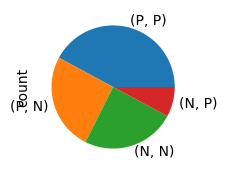

In [31]:
RESULT.value_counts(['prediction','doc_label']).plot.pie(figsize=(2,2));

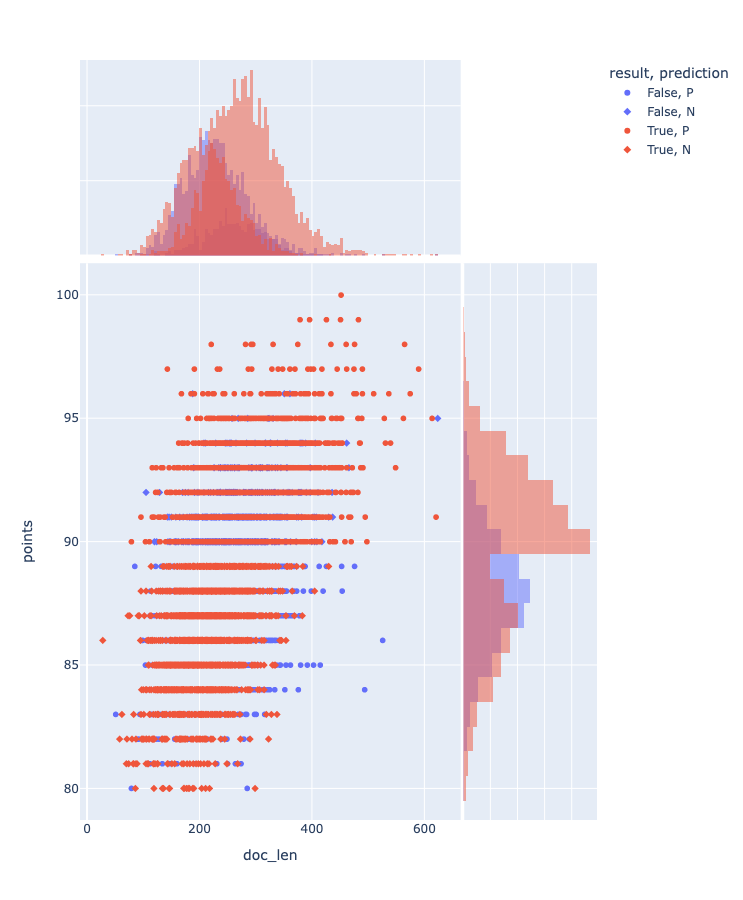

In [53]:
px.scatter(RESULT.join(DOC[['doc_content','points','doc_len']], how='inner').reset_index(), 'doc_len', 'points', color='result', symbol='prediction',
           height=900, width=1000, marginal_x='histogram', marginal_y='histogram')

In [32]:
CM = RESULT.value_counts(['prediction','doc_label']).unstack()

In [33]:
CM

doc_label,N,P
prediction,,
N,1966,627
P,2037,3370


In [34]:
def get_results(CM, model_id):
    
    R = pd.DataFrame(index=[model_id])
    R.index.name = 'model_id'
    
    # COUNTS
    R['TN'] = CM.iloc[0,0]   # correct rejections
    R['FN'] = CM.iloc[0,1]   # Type II errors or misses
    R['TP'] = CM.iloc[1,1]   # hits
    R['FP'] = CM.iloc[1,0]   # Type I errors or false alarms
    R['T'] = R.TP + R.TN     # All True
    R['F'] = R.FP + R.FN     # All False
    R['ALL'] = R['T'] + R.F  # All
    
    assert R.ALL.values[0] == CM.sum().sum()
    
    # RATIOS
    R['ACC'] = R['T'] / R.ALL                        # (Simple) Accuracy
    R['TPR'] = R.TP / (R.TP + R.FN)                  # Recall or Sensitivity
    R['TNR'] = R.TN / (R.TN + R.FP)                  # Specificity
    R['PPV'] = R.TP / (R.TP + R.FP)                  # Precision or Positive predictive value 
    R['BA'] = (R.TNR + R.TPR) / 2                    # Balanced Accuracy
    R['F1'] = (2 *  R.TP) / (2 * R.TP + R.FP + R.FN) # F-score where F = 1

    return R

In [35]:
R = get_results(CM, 'mi')
R.index.name = 'model_id'

In [36]:
R.T.style.format(precision=3)

model_id,mi
TN,1966.000
FN,627.000
TP,3370.000
FP,2037.000
T,5336.000
F,2664.000
ALL,8000.000
ACC,0.667
TPR,0.843
TNR,0.491


# Extract Sentiment

In [37]:
SALEX = PMI
SALEX['valence'] = SALEX.P - SALEX.N
SALEX = SALEX.sort_values('valence')

In [38]:
SALEX['polarity'] = np.sign(SALEX.valence)

In [39]:
from sklearn.preprocessing import MinMaxScaler

In [40]:
scaler = MinMaxScaler(feature_range=(-1, 1))
SALEX['normalized'] = scaler.fit_transform(SALEX[['valence']])

In [41]:
SALEX.sort_values('valence', ascending=False).head(20)

doc_label,N,P,valence,polarity,normalized
term_str,,,,,
91,-7.391523,1.695000,9.086523,1.0,1.000000
exquisite,-7.387103,1.473892,8.860995,1.0,0.975737
2035,-7.379558,0.992099,8.371657,1.0,0.923091
dazzling,-7.379113,0.957863,8.336975,1.0,0.919360
impeccable,-7.378222,0.886783,8.265006,1.0,0.911617
extraordinary,-7.375993,0.691615,8.067609,1.0,0.890380
radiant,-7.375993,0.691615,8.067609,1.0,0.890380
2032,-7.374654,0.560097,7.934751,1.0,0.876086
explosion,-7.373761,0.465095,7.838856,1.0,0.865769


In [42]:
SALEX.sort_values('valence', ascending=True).head(20)

doc_label,N,P,valence,polarity,normalized
term_str,,,,,
watery,1.771130,-7.732237,-9.503366,-1.0,-1.000000
dilute,1.467286,-7.727356,-9.194642,-1.0,-0.966786
melony,1.371541,-7.726022,-9.097563,-1.0,-0.956342
mealy,1.268791,-7.724687,-8.993478,-1.0,-0.945143
weedy,1.118970,-7.722905,-8.841874,-1.0,-0.928833
diluted,1.078888,-7.722459,-8.801347,-1.0,-0.924473
scouring,0.995140,-7.721566,-8.716707,-1.0,-0.915367
chemical,0.281317,-7.715754,-7.997071,-1.0,-0.837945
clipped,0.131008,-7.714857,-7.845865,-1.0,-0.821677


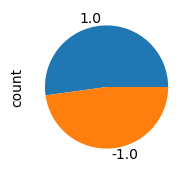

In [43]:
SALEX.polarity.value_counts().plot.pie(figsize=(2,2));

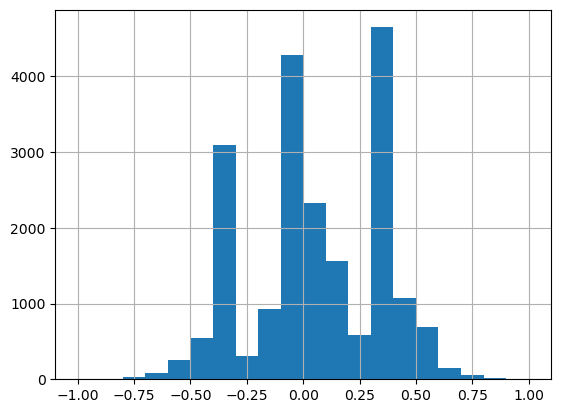

In [44]:
SALEX.normalized.hist(bins=20);

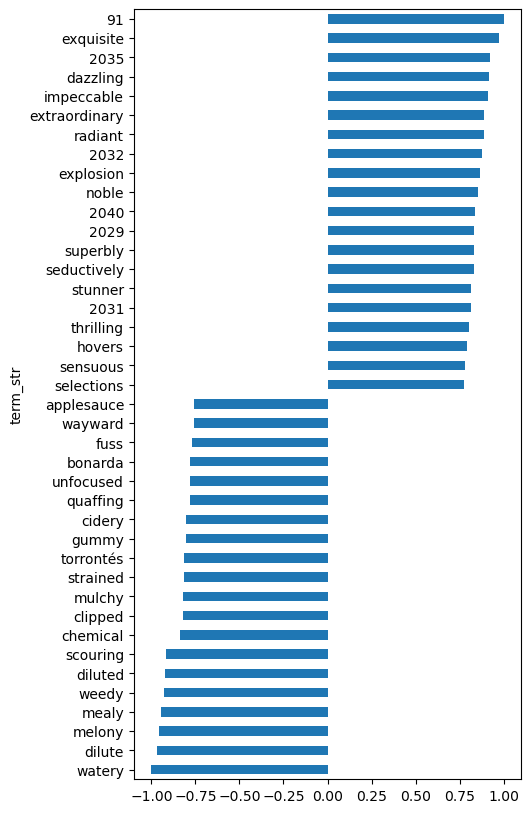

In [45]:
pd.concat([SALEX.normalized.head(20),SALEX.normalized.tail(20)]).plot.barh(figsize=(5,10));

# Save

In [46]:
SALEX[['valence','polarity','normalized']].to_csv(f"{data_path}-MI_SALEX.csv")

In [47]:
R.to_csv(f"{data_path}-MI_RESULT.csv", index=True)